# Vehicle Detection

The goal of this project is to detect vehicles on a video recorded from inside of a car. The detected cars has to be identified in the video by drawing boxes around them.

A pool of vehicle and non-vehicle images are provided by Udacity in order to be used as training and testing set to train a computer learning model to identify vehicles from non-vehicle images.

## Importing libraries and methods

In [1]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
import time
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip

## Load data

In [2]:
car_imgs = glob.glob('training/vehicles/**/*.png')

noncar_imgs = glob.glob('training/non-vehicles/**/*.png')

print(len(car_imgs), len(noncar_imgs))

8792 8968


## Visualizing some samples

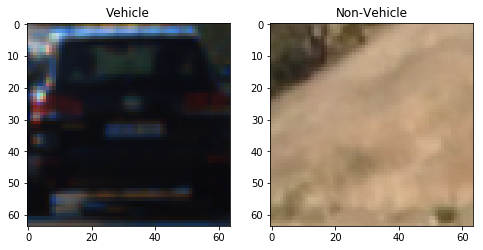

In [3]:
# Load in Test Images
test_vehicle = cv2.imread(car_imgs[np.random.randint(0,len(car_imgs))])

test_vehicle = cv2.cvtColor(test_vehicle,cv2.COLOR_BGR2RGB)

test_nonvehicle = cv2.imread(noncar_imgs[np.random.randint(0,len(car_imgs))])

test_nonvehicle = cv2.cvtColor(test_nonvehicle,cv2.COLOR_BGR2RGB)

# Plot Test Images for Vechicle and Non-Vehicle
plt.figure(figsize=(8,4))

plt.subplot(1, 2, 1)

plt.title('Vehicle')

plt.imshow(test_vehicle)

plt.subplot(1, 2, 2)

plt.imshow(test_nonvehicle)

plt.title('Non-Vehicle')

plt.show()

## Extract HOG features method

In [4]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    
    if vis==True:
        
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        
        return features, hog_image
    
    else:
        
        features = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        
    return features

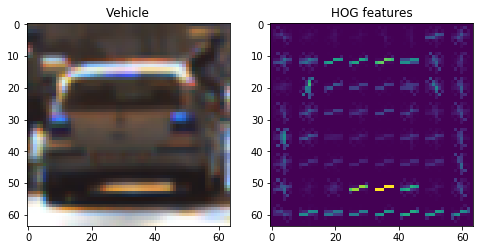

In [32]:
# Visualizing a HOG feature sample
test_vehicle = cv2.imread(car_imgs[np.random.randint(0,len(car_imgs))])

test_vehicle_hog, test_vehicle_hogvis = get_hog_features(test_vehicle[:,:,0], 9, 8, 2,vis=True,feature_vec=True)

plt.figure(figsize=(8,4))

plt.subplot(1, 2, 1)

plt.title('Vehicle')

plt.imshow(test_vehicle)

plt.subplot(1, 2, 2)

plt.imshow(test_vehicle_hogvis)

plt.title('HOG features')

plt.show()

## Defining method for feature extraction

In [6]:
# Create Color Conversion Function - From Lessons
def convert_color(img, conv='RGB2YCrCb'):
    
    if conv == 'RGB2YCrCb':
        
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    
    if conv == 'BGR2YCrCb':
        
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    
    if conv == 'RGB2LUV':
        
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

    
# # Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    
    # Use cv2.resize().ravel() to create the feature vector
    bin_features = cv2.resize(img, size).ravel() 
    
    # Return the feature vector
    return bin_features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


In [ ]:
# Define a function to extract features from a list of images
def extract_features(imgs, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    
    # Create a list to append feature vectors to
    features_img = []
    
    features = []
    
    # Iterate through the list of images
    for file in imgs:
        
        # Read in each one by one
        image = mpimg.imread(file)
        
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            
            if cspace == 'HSV':
                
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
                
            elif cspace == 'LUV':
                
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
                
            elif cspace == 'HLS':
                
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
                
            elif cspace == 'YUV':
                
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
                
            elif cspace == 'YCrCb':
                
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
                
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'All':
            
            hog_features = []
            
            for channel in range(feature_image.shape[2]):
                
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
                
            hog_features = np.ravel(hog_features)   
            
        else:
            
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        # extracting bin spatial features
        bin_features = bin_spatial(feature_image, size=(32, 32))
        
        #extracting color histogram 
        hist_features = color_hist(feature_image, nbins=32, bins_range=(0, 256))
        
        #stack all features into features parameter
        features_img=np.hstack((hog_features, bin_features, hist_features))
        
        features.append(features_img)
    
    # Return list of feature vectors
    return features

In [30]:
# Create a set of 1000 images of vehicle and non-vehicle for test
test_vehicle = car_imgs[0:1000]

test_nonvehicle = noncar_imgs[0:1000]

# Create Labels
labels_vehicle = np.ones(len(test_vehicle), dtype=np.int)

labels_nonvehicle = np.zeros(len(test_nonvehicle), dtype=np.int)

# extract all desired features
vehicle_train=extract_features(test_vehicle, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0)

nonvehicle_train=extract_features(test_nonvehicle, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0)

print('Test set of vehicle images has', len(vehicle_train),
      'sets of images and', len(labels_vehicle),' labels')

print('Test set of non-vehicle images has', len(nonvehicle_train),
      'sets of images and', len(labels_nonvehicle),' labels')

Test set of vehicle images has 1000 sets of images and 1000  labels
Test set of non-vehicle images has 1000 sets of images and 1000  labels


## Training model over train and test data set

In [9]:
# Defining parameter values
cspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb

orient = 9

pix_per_cell = 8

cell_per_block = 2

hog_channel = 'All' # Can be 0, 1, 2, or "ALL"

test_vehicle = car_imgs

test_nonvehicle = noncar_imgs

# Create Labels
labels_vehicle = np.ones(len(test_vehicle), dtype=np.int)

labels_nonvehicle = np.zeros(len(test_nonvehicle), dtype=np.int)

# extract all desired features
vehicle_train=extract_features(test_vehicle, cspace, orient, pix_per_cell, cell_per_block, hog_channel)

nonvehicle_train=extract_features(test_nonvehicle, cspace, orient, pix_per_cell, cell_per_block, hog_channel)

# Stack vehicle and non-vehicle images in a list
X = np.vstack((vehicle_train, nonvehicle_train)).astype(np.float64)

# Normalizing feature values
X_scaler = StandardScaler().fit(X)

scaled_X = X_scaler.transform(X)

# Stack vehicle and non-vehicle labels in a list
y = np.hstack((labels_vehicle, labels_nonvehicle))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')

print('Feature vector length:', len(X_train[0]))

# Use a linear SVC model
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()

svc.fit(X_train, y_train)

t2 = time.time()

print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()

n_predict = 10

print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))

print('For these',n_predict, 'labels: ', y_test[0:n_predict])

t2 = time.time()

print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
42.35 Seconds to train SVC...
Test Accuracy of SVC =  0.9918
My SVC predicts:  [0 0 0 1 0 1 1 1 0 0]
For these 10 labels:  [0 0 0 1 0 1 1 1 0 0]
0.08 Seconds to predict 10 labels with SVC


## Sliding window search and detection

In [10]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    # create a copy of image
    draw_img = np.copy(img)
    
    # scaling the image to be in range of 0 to 1
    img = img.astype(np.float32)/255
    
    # limiting the search area to lower portion of the image
    img_tosearch = img[ystart:ystop,:,:]
    
    # convert color space to YCrCb
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    
    # creating boxlist parameter
    bbox_list=[]
    
    # reshape image if scaling applied
    if scale != 1:
        
        imshape = ctrans_tosearch.shape
        
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale),np.int(imshape[0]/scale)))
        
    # extracting color channels
    ch1 = ctrans_tosearch[:,:,0]
    
    ch2 = ctrans_tosearch[:,:,1]
    
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps
                    
        for yb in range(nysteps):
                    
            ypos = yb*cells_per_step
                    
            xpos = xb*cells_per_step
                    
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    
            hog_features1 = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
                    
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features1 = bin_spatial(subimg, size=spatial_size)
                    
            hist_features1 = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            h=np.hstack((hog_features1, spatial_features1, hist_features1)).reshape(1, -1)
                    
            test_features = X_scaler.transform(h)    
            
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))          
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                    
                xbox_left = np.int(xleft*scale)
                    
                ytop_draw = np.int(ytop*scale)
                    
                win_draw = np.int(window*scale)
                    
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),
                              (xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
                bbox_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return draw_img, bbox_list

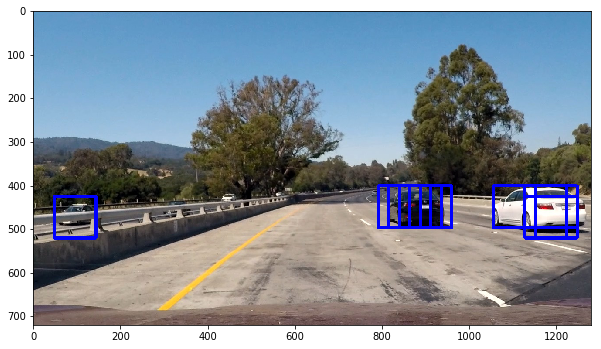

In [40]:
# Function test and visualization

ystart = 400

ystop = 656

scale = 1.5

spatial_size = (32,32)

img = mpimg.imread('test_images/test1.jpg')

hist_bins = 32

out_img, bbox_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.figure(figsize=(10,10))

plt.imshow(out_img)

plt.show()

## Defining heat map, thresholding pixel values and drawing box around  heated areas

In [12]:
# Method to create a heat map based on the detected cars by multiple boxes
def add_heat(heatmap, bbox_list):
    
    # Iterate through list of bboxes
    for box in bbox_list:
        
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes




# Method to apply a threshold to eliminate false positives
def apply_threshold(heatmap, threshold):
    
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    
    # Return thresholded map
    return heatmap




# Method to draw boxes around features in heat map which were thresholded
def draw_labeled_bboxes(img, labels):
    
    boxes=[]
    
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        
        nonzerox = np.array(nonzero[1])
        
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        
        boxes.append(bbox)
        
    # Return the image
    
    return img, boxes


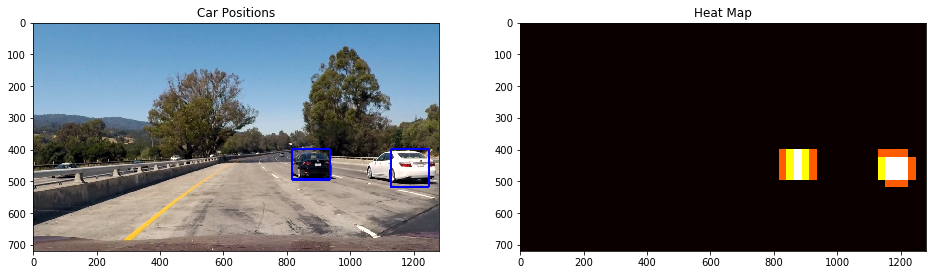

In [36]:
# Read in image similar to one shown above 
heat = np.zeros_like(img[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,bbox_list)

# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying  
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)

draw_img, boxes = draw_labeled_bboxes(np.copy(img), labels)

plt.figure(figsize=(16,16))

# fig = plt.figure

plt.subplot(121)

plt.imshow(draw_img)

plt.title('Car Positions')

plt.subplot(122)

plt.imshow(heatmap, cmap='hot')

plt.title('Heat Map')

fig.tight_layout()

plt.show()

## Defining a class to store data from processed frames

In [ ]:

class Car():
    def __init__(self):
        
        #list to store boxes from n previous frames
        self.recent_fits = []
        
        #length of the last box corners list
        self.last_fit_len = 0
        
        #counter to update recent_fits parameter during each frame process
        self.counter = 0
        

## Creating a pipeline for video processing

In [ ]:
def car_position(img):
    
    # Defining a list to store box coordinations
    
    bbox_list = []
    
    #Defining region of interest in the frame
    
    ystart = 400
    
    ystop = 656
    
    # Performing feature analysis for different box sizes
    
    scale = 1.0
    bbox_list.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                               orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)[1])

    scale = 1.5
    bbox_list.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                               orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)[1])

    scale = 2.0
    bbox_list.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                               orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)[1])

    scale = 2.5
    bbox_list.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                               orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)[1])

    scale = 3.0
    bbox_list.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                               orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)[1])

    # Read in image similar to one shown above 
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,bbox_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    draw_img, boxes = draw_labeled_bboxes(np.copy(img), labels)

    # Storing data from the previous frames in a Car class instance
    if car.counter < 5:
        
        car.recent_fits.extend(boxes)
        
    else:
        
        del car.recent_fits[0:car.last_fit_len]
        
        car.recent_fits.extend(boxes)
        
    car.counter += 1
    
    if car.counter == 10:
        
        car.counter = 5
    
    car.last_fit_len = len(boxes)
    
    # Read in image similar to one shown above 
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,car.recent_fits)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    draw_img, boxes = draw_labeled_bboxes(np.copy(img), labels)
    
    # Returning image with boxes drawn on
    return draw_img

In [ ]:
# Initiating one instance of Car class to store data from each frame analysis
car=Car()

## Running car detection on videos

In [27]:
#Running a short test video
project_output = 'test_processed.mp4'

clip1 = VideoFileClip("test.mp4")

processed_video = clip1.fl_image(car_position) #NOTE: this function expects color images!!

%time processed_video.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video test_processed.mp4
[MoviePy] Writing video test_processed.mp4



100%|████████████████████████████████████████████████████████████████████| 76/76 [03:24<00:00,  2.74s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_processed.mp4 

Wall time: 3min 25s


In [ ]:
# Running the project video
project_output = 'project_video_processed.mp4'

clip1 = VideoFileClip("project_video2.mp4")

processed_video = clip1.fl_image(car_position) #NOTE: this function expects color images!!

%time processed_video.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_video_processed.mp4
[MoviePy] Writing video project_video_processed.mp4



  6%|███▉                                                              | 76/1261 [03:25<55:05,  2.79s/it]


 12%|███████▉                                                         | 153/1261 [06:53<51:49,  2.81s/it]


 18%|███████████▊                                                     | 230/1261 [10:22<46:10,  2.69s/it]


 24%|███████████████▊                                                 | 307/1261 [13:54<42:34,  2.68s/it]


 30%|███████████████████▊                                             | 384/1261 [17:25<39:29,  2.70s/it]


 37%|███████████████████████▊                                         | 461/1261 [20:52<35:57,  2.70s/it]


 43%|███████████████████████████▋                                     | 538/1261 [24:21<32:38,  2.71s/it]


 49%|███████████████████████████████▋                                 | 615/1261 [27:51<29:38,  2.75s/it]


 55%|███████████████████████████████████▋                             | 692/1261 [31:21<26:00,  2.74s/it]


 61%|███████████████████████████████████████▋                         | 769/1261 [34:53<22:08,  2.70s/it]


 67%|███████████████████████████████████████████▌                     | 846/1261 [38:22<18:39,  2.70s/it]


 73%|███████████████████████████████████████████████▌                 | 923/1261 [41:52<15:31,  2.76s/it]


 79%|██████████████████████████████████████████████████▊             | 1000/1261 [45:21<11:57,  2.75s/it]


 85%|██████████████████████████████████████████████████████▋         | 1077/1261 [48:51<08:16,  2.70s/it]


 92%|██████████████████████████████████████████████████████████▌     | 1154/1261 [52:21<04:49,  2.71s/it]


 98%|██████████████████████████████████████████████████████████████▍ | 1231/1261 [55:49<01:20,  2.70s/it]


100%|███████████████████████████████████████████████████████████████▉| 1260/1261 [57:07<00:02,  2.68s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_processed.mp4 

Wall time: 57min 9s


In [21]:
# Code to split videos
# ffmpeg_extract_subclip("project_video.mp4", 0, 3, targetname="test.mp4")


[MoviePy] Running:
>>> ffmpeg -y -i project_video.mp4 -ss 0.00 -t 3.00 -vcodec copy -acodec copy test.mp4
... command successful.
